In [1]:
%matplotlib inline

%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

import cv2
import numpy as np
import pandas as pd
import skimage

import pims
import trackpy as tp
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('figure', figsize=(20,12))
mpl.rc('image', cmap='gray')

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

In [2]:
#Here, you can change where the image files are being fetched from. 
fileName = 'paraffinEFieldSpacing-250V-8ms.png'
prefix = './data/'
path = prefix + fileName

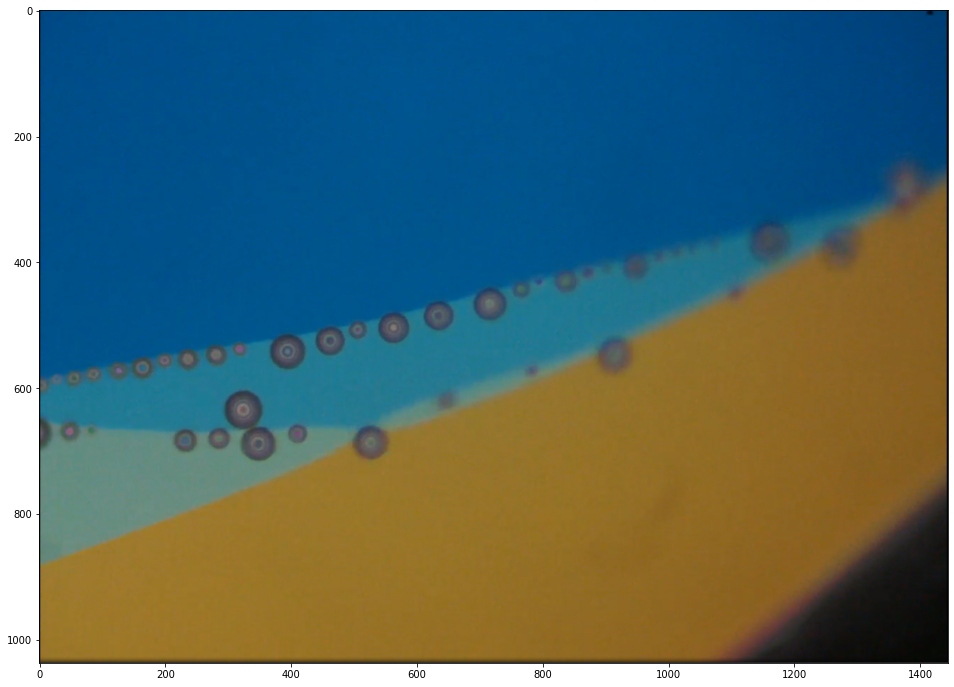

In [3]:
#This displays the first image in the progression, and imports all of them. 
imraw = plt.imread(path)
plt.imshow(imraw)


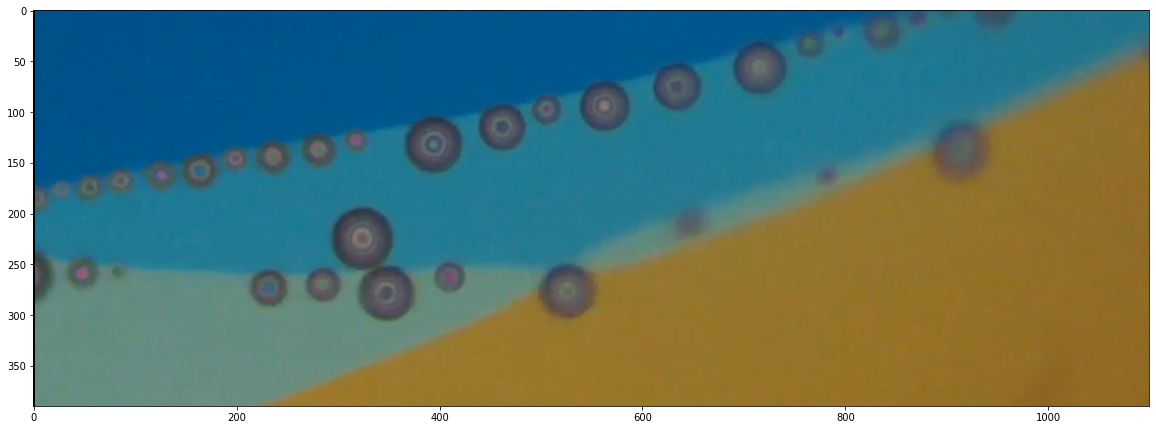

In [4]:
def crop(img):
    x_min = 0
    x_max = 1100
    y_min = 410
    y_max = 800
    return img[y_min:y_max,x_min:x_max]

im = crop(imraw)


plt.imshow(im)


<ipython-input-5-c92961cc8f14>:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  imgc = skimage.color.rgb2gray(imgc)


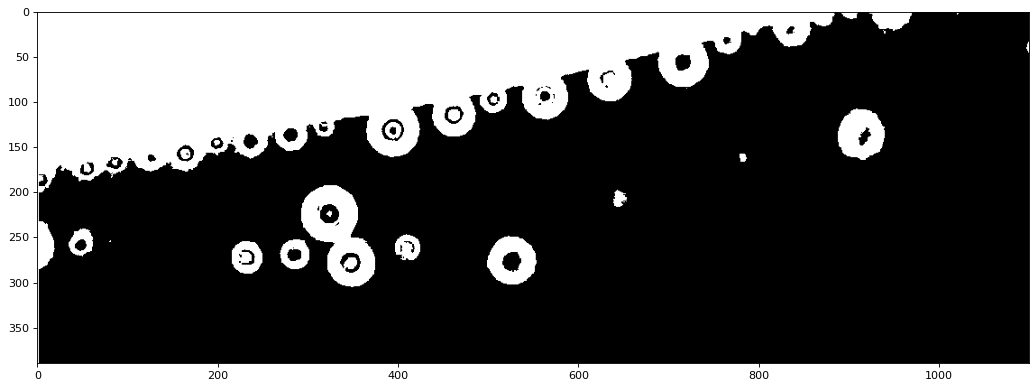

In [5]:
#This converts the image to a binary, black and white file so that the islands can be tracked. 
from scipy import ndimage
from skimage import morphology, util, filters
import cv2
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')


def preprocess_film(img):
    imgc = crop(img)
    imgc = skimage.color.rgb2gray(imgc)
    
    threshold = .38
    idx = imgc > threshold
    idx2 = imgc < threshold
    idx3 = imgc == threshold
    imgc[idx] = 0
    imgc[idx2] = 255
    imgc[idx3] = 255
    
    
    return imgc

im = preprocess_film(imraw)
# im = skimage.color.rgb2gray(im)
# frames = preprocess_film(pims.open(os.path.join(datapath, prefix + '*.tif')))

# frames = pims.open(os.path.join(datapath, prefix + '*.tif'))
#print(frames[id_example])

plt.imshow(im)



Found 47 features


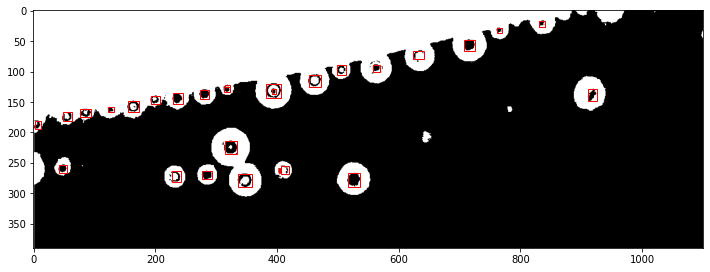

In [6]:
import skimage
import matplotlib.patches as mpatches

white = 255
label_image, number_of_labels = skimage.measure.label(im, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(im, cmap='gray')
for region in skimage.measure.regionprops(label_image, intensity_image=im):
    if region.area < 10 or region.area > 3000:
        continue
        
    if region.mean_intensity > 1:
        continue
    
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc -minc, maxr - minr, 
                             fill=False, edgecolor='red', linewidth=1)
    
    ax.add_patch(rect)

In [7]:
#Stores these images in a panda sequence
features = pd.DataFrame()

label_image, number_of_labels = skimage.measure.label(im, background=white, return_num=True)

index = 0

for region in skimage.measure.regionprops(label_image, intensity_image=im):
    if region.area < 10 or region.area > 20000:
        continue
        
    if region.mean_intensity > 1:
        continue
    index += 1
    features = features.append([{'index':index, 'y':region.centroid[0], 'x':region.centroid[1], 'Area (px^2)':region.area}])
features = features.set_index('index')

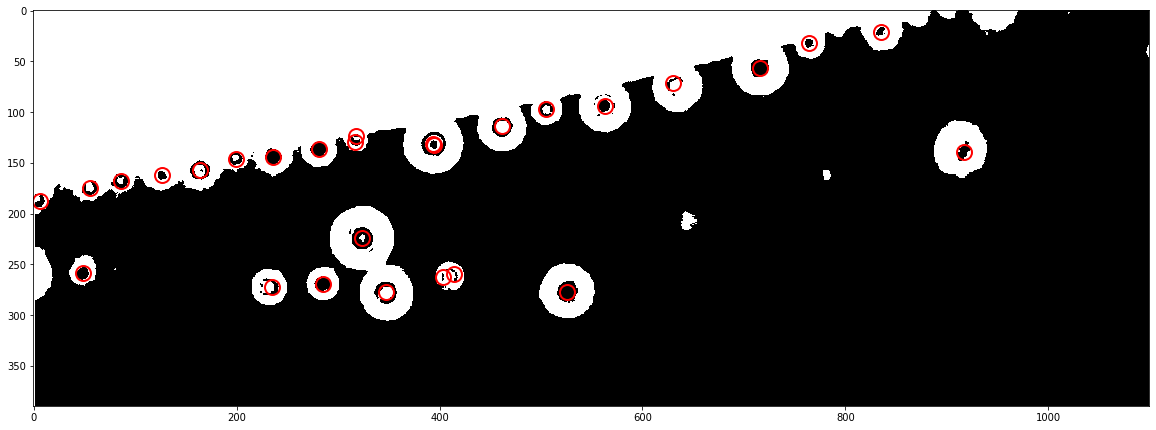

<AxesSubplot:>

In [8]:
#Displays the features which will be tracked in the next part
tp.annotate(features, im)

In [9]:
numFeatures = len(features.index)
closest = []

for p in range(1, numFeatures+1):
    testRange = features.drop(p, axis=0)
    distances = []

    for i in range(1, p-1):
        start = features.loc[p,:]
        end = testRange.loc[i,:]
        sx = start.x
        ex = end.x
        sy = start.y
        ey = end.y
        dx = (sx-ex)*(sx-ex)
        dy = (sy-ey)*(sy-ey)
        
        dist = np.sqrt(dx+dy)
        distances = np.append(distances, dist)

    for o in range(p+1, numFeatures):
        start = features.loc[p,:]
        end = testRange.loc[o,:]
        sx = start.x
        ex = end.x
        sy = start.y
        ey = end.y
        dx = (sx-ex)*(sx-ex)
        dy = (sy-ey)*(sy-ey)
        
        dist = np.sqrt(dx+dy)
        distances = np.append(distances, dist)
    
    close=np.amin(distances)
    closest = np.append(closest,close)
    # features = features.append([{'closest':close}])

features['Seperation (px)']=closest
maxd = np.amax(closest)
mind = np.amin(closest)
devd = np.std(closest)
avclosest = np.average(closest)
print("the average seperation of the features is ", avclosest, " pixels, with a standard deviation of ", devd)

the average seperation of the features is  54.3685862743759  pixels, with a standard deviation of  31.71931333233561


In [10]:
print(closest)
print(features)

[ 71.31259072  54.40429552  87.132832    70.88607411  57.68436581
  47.1609263   69.42598669   1.19671851   6.26460365  36.73329809
   1.19671851 143.88013463  36.73329809  37.05448087  36.47845174
  38.170426    41.08353182  31.20731416  50.44582449  81.63686936
  59.76154871  82.39283804  11.44022424  88.26042842  49.84729865
  59.76154871 112.87789915  57.88988867]
                y           x  Area (px^2)  Seperation (px)
index                                                      
1       20.826923  834.923077           52        71.312591
2       32.180000  764.520000           50        54.404296
3       56.365462  715.787149          249        87.132832
4       70.912281  629.877193           57        70.886074
5       93.888889  562.818182           99        57.684366
6       96.811881  505.207921          101        47.160926
7      114.069364  461.317919          173        69.425987
8      131.069652  393.756219          201         1.196719
9      123.384615  318.076923

<AxesSubplot:title={'center':'Droplet Seperation vs Droplet Area, No E-Field'}, xlabel='Area (px^2)', ylabel='Seperation (px)'>

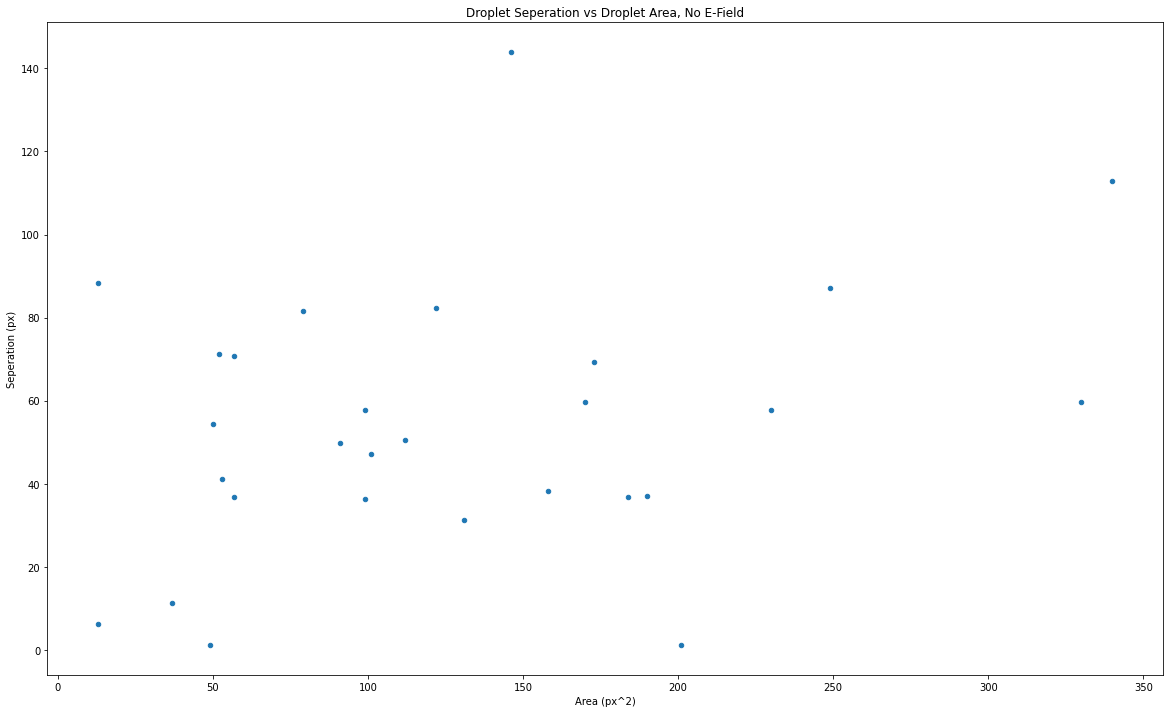

In [11]:
features.plot('Area (px^2)', 'Seperation (px)', 'scatter', title='Droplet Seperation vs Droplet Area, No E-Field')